In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Put 12 Months in One File

In [2]:
#12 months of data into a signle file
from os import listdir
from os.path import isfile, join

mypath='./Sales_Data/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
all_months_data=pd.DataFrame()
lines=0

myorder=[8,2,3,1,5,11,10,4,9,7,6,0]
ordered_months = files
ordered_months = [ordered_months[i] for i in myorder]

for i in ordered_months:
    temp_=pd.read_csv(mypath+i)
    all_months_data=pd.concat([all_months_data,temp_])
    lines=lines+(temp_.count())
    
all_months_data.to_csv('all_data.csv',index=False)

In [3]:
all_data=pd.read_csv('all_data.csv')

## Best Month for Sales? Earnigns?

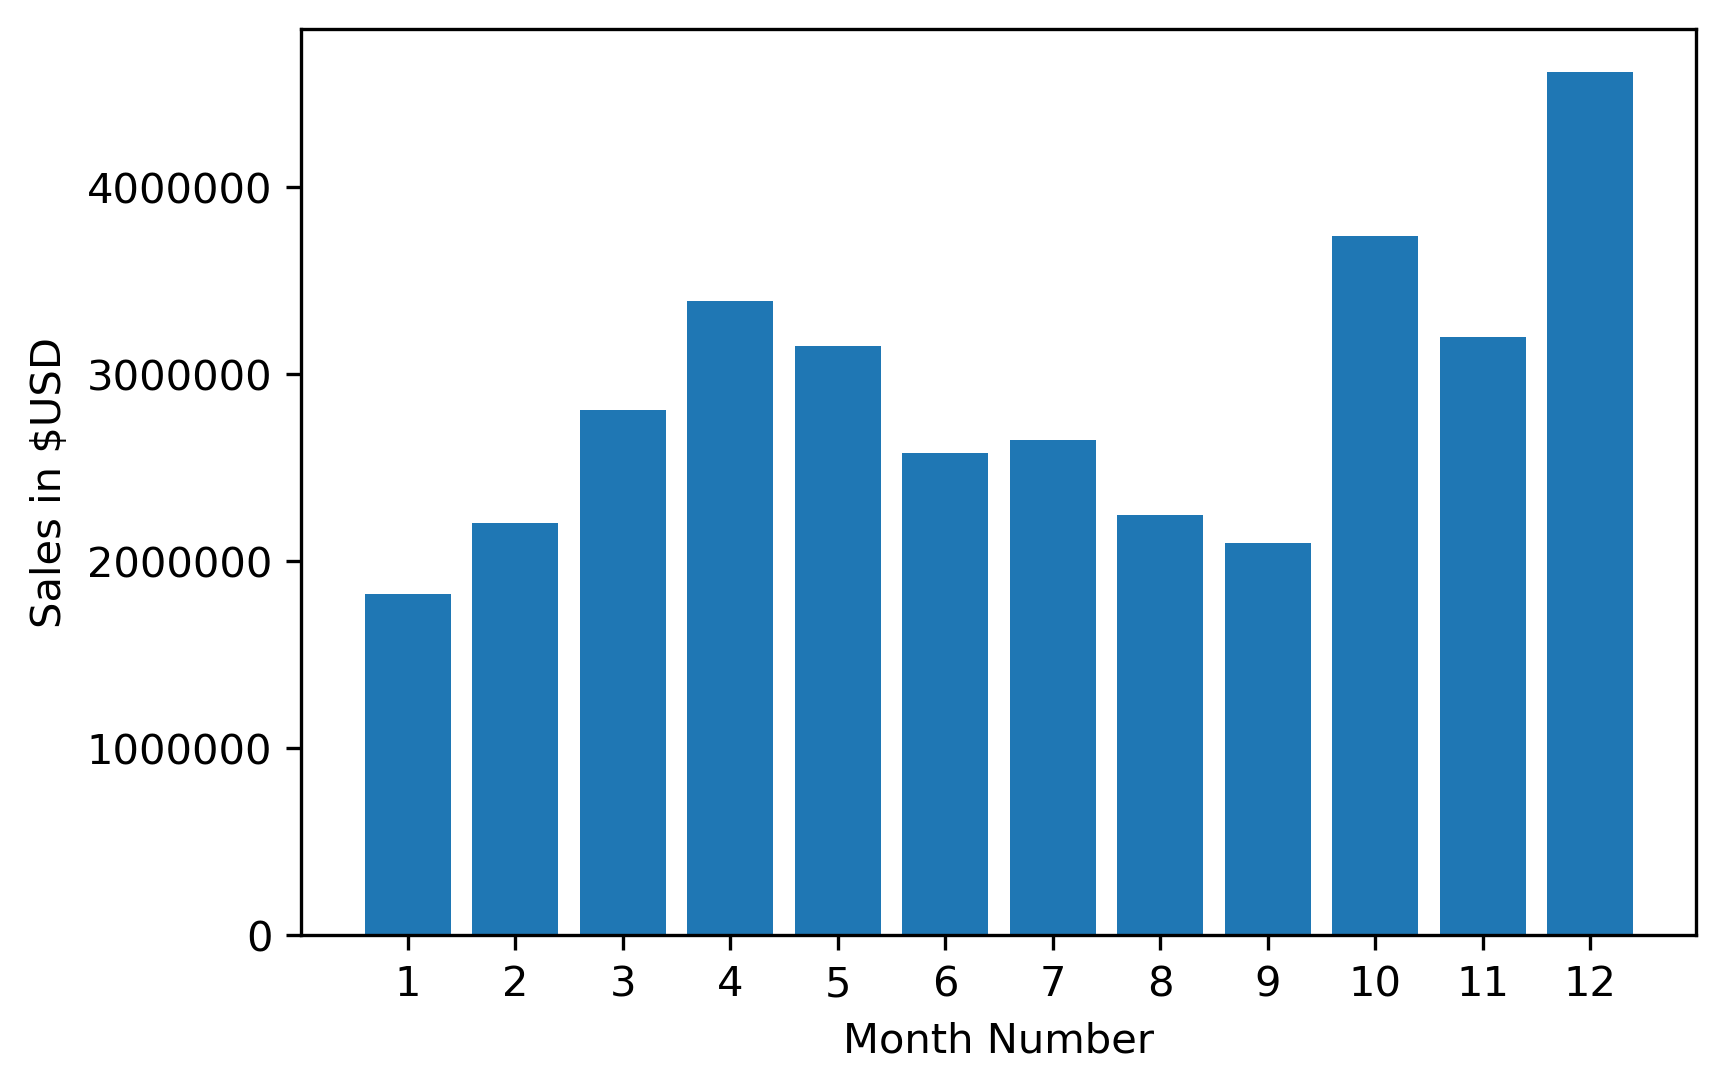

In [4]:
# Clean Data from NAN
# Drop all rows with NAN
nan_df=all_data[all_data.isna().any(axis=1)]
all_data=all_data.dropna(how='any') # any:for any singe nan , all: for whole rows of NaN

# Remove weird Or Error
all_data=all_data[all_data['Order Date'].str[0:2]!='Or']

# Create Month Column
all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype('int32')
all_data.head()

# Create Sales Column
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']
all_data.head()

# Sum of each month
month_sales_sum=all_data.groupby('Month').sum()

# Visualize
months=range(1,13)
plt.figure(figsize=(6,4),dpi=300)
plt.bar(months,month_sales_sum['Sales'])
plt.xticks(months)
plt.ylabel('Sales in $USD')
plt.xlabel('Month Number')

plt.show()

## City with highest number of sales

In [5]:
all_data['Purchase Address'].head()

0          944 Walnut St, Boston, MA 02215
1         185 Maple St, Portland, OR 97035
2    538 Adams St, San Francisco, CA 94016
3       738 10th St, Los Angeles, CA 90001
4            387 10th St, Austin, TX 73301
Name: Purchase Address, dtype: object

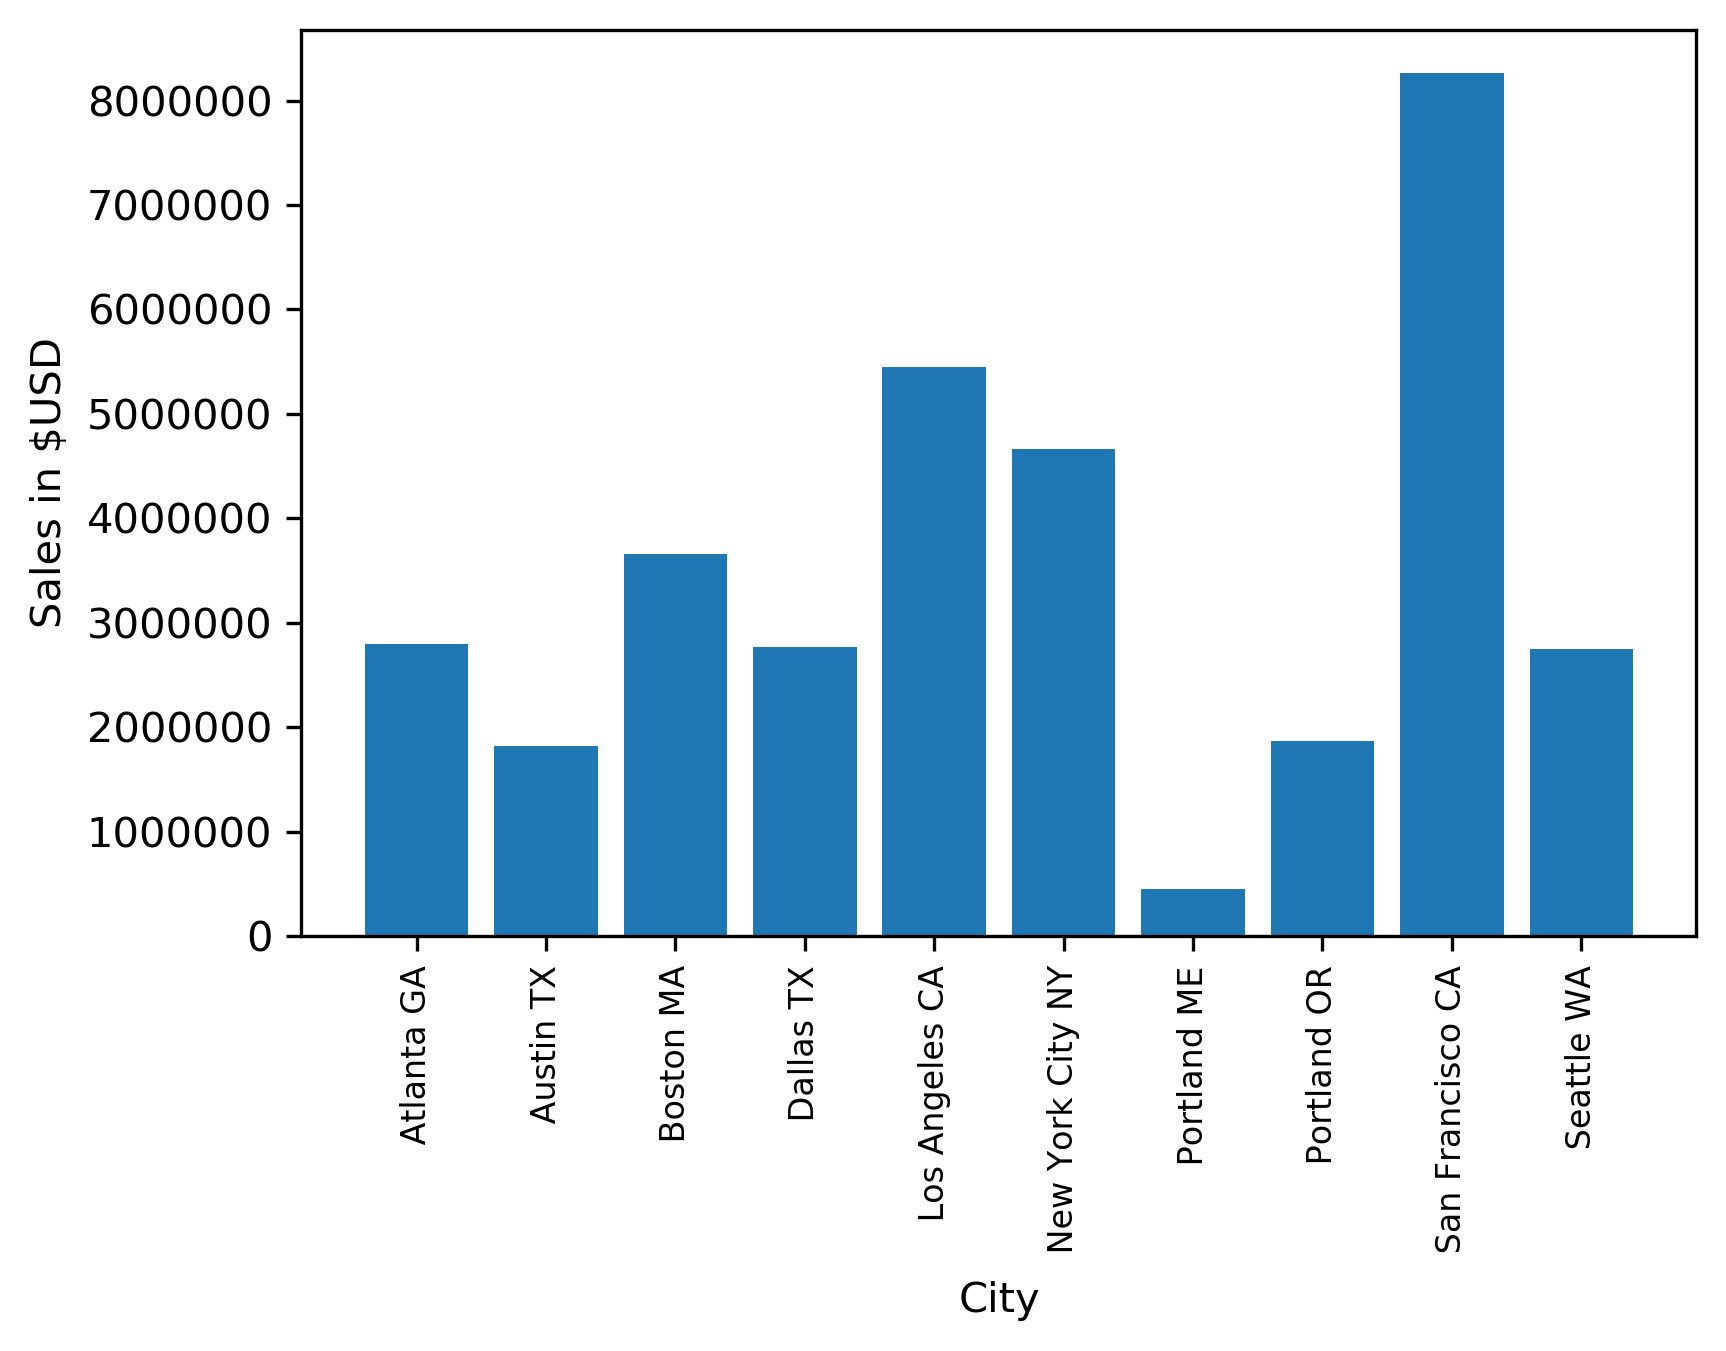

In [6]:
# Create City Column
# .apply : apply any function #insane
def get_city_state(address,qq):
    if qq==1:
        return address.split(',')[1]
    else:
         return address.split(',')[2].split(' ')[1]
# Create City State Column
all_data['State'] = all_data['Purchase Address'].apply(lambda x: get_city_state(x,1)+' '+get_city_state(x,2))

# Sum of each month
city_sales_sum=all_data.groupby('State').sum()

# Visualize
cities=[ city for city, df in all_data.groupby('State')]

plt.figure(figsize=(6,4),dpi=300)
plt.bar(cities,city_sales_sum['Sales'])
plt.xticks(cities,rotation='vertical',size=8)
plt.ylabel('Sales in $USD')
plt.xlabel('City')

plt.show()

## Optimal Ad Timing

In [7]:
# Add hour column, set datatype to_datetime
all_data['Hour'] = pd.to_datetime(all_data['Order Date']).dt.hour
all_data['Minute'] = pd.to_datetime(all_data['Order Date']).dt.minute
all_data['Count'] = 1
all_data.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,State,Hour,Minute,Count
0,141234,iPhone,1,700.00,01/22/19 21:25,"944 Walnut St, Boston, MA 02215",1,700.00,Boston MA,21,25,1
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035",1,14.95,Portland OR,14,15,1
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016",1,23.98,San Francisco CA,13,33,1
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001",1,149.99,Los Angeles CA,20,33,1
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301",1,11.99,Austin TX,11,59,1


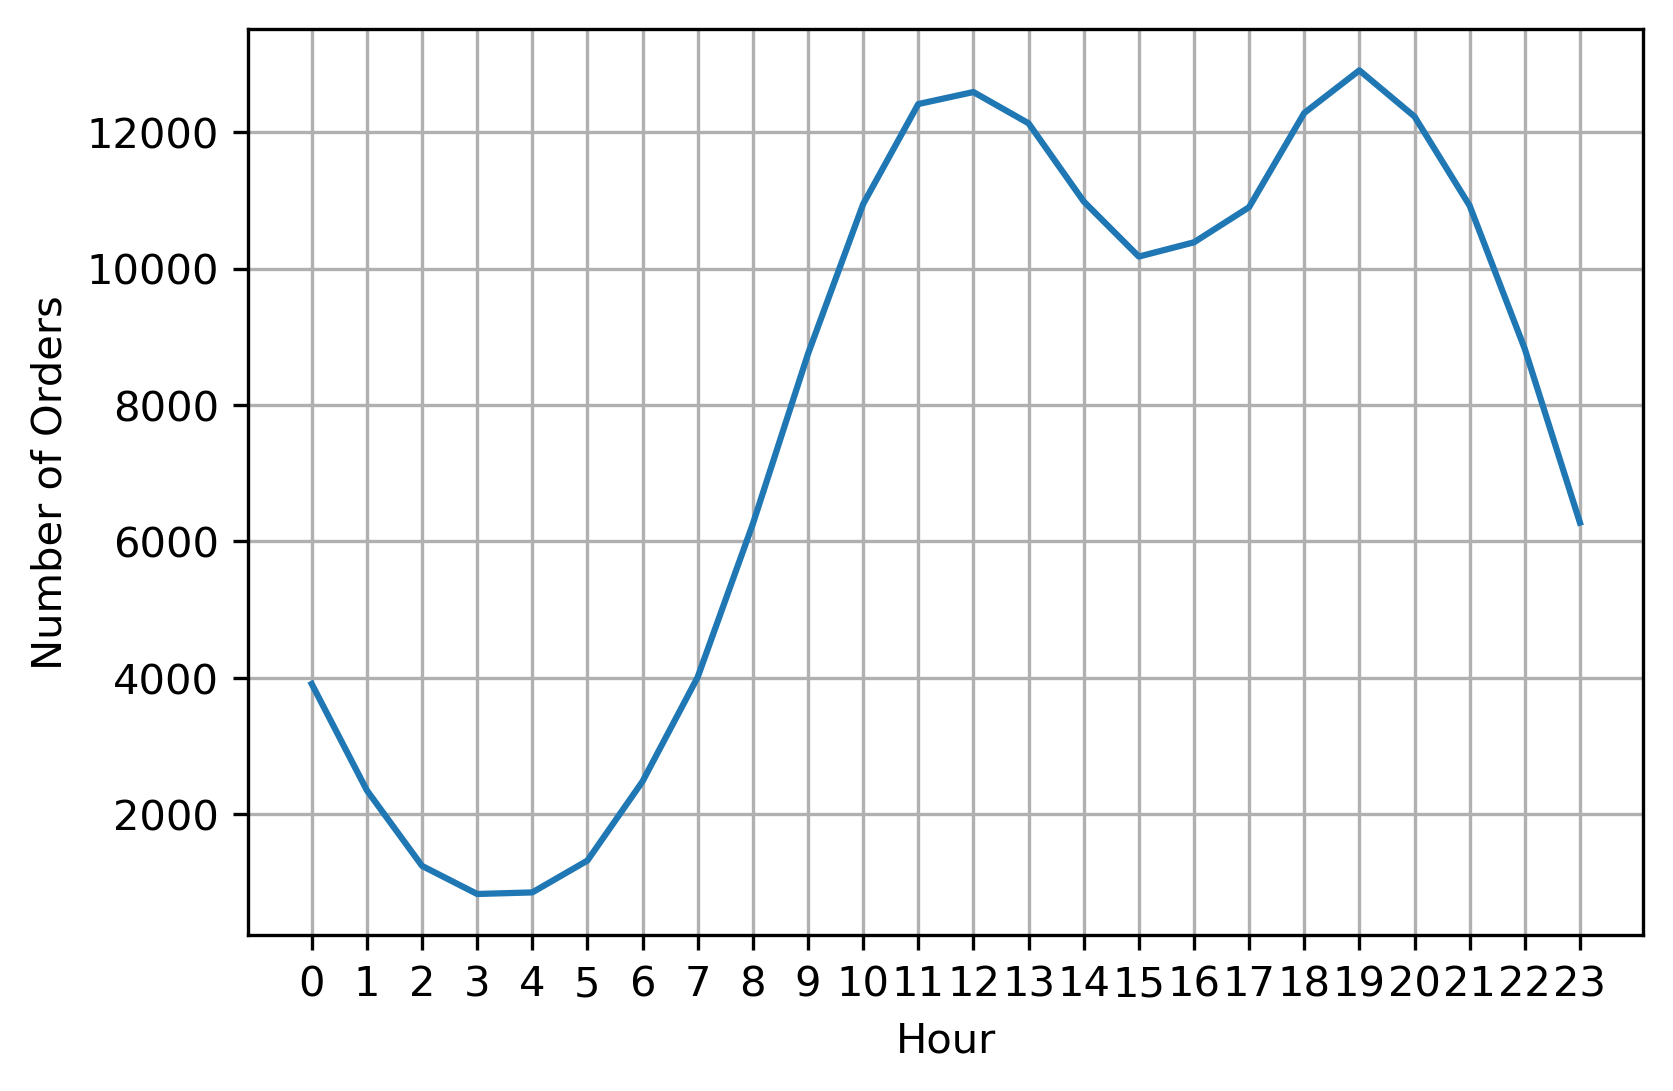

In [11]:
hours = [hour for hour, df in all_data.groupby(['Hour'])]

plt.figure(figsize=(6,4),dpi=300)
plt.plot(hours, all_data.groupby(['Hour']).count()['Count'])
plt.xticks(hours)
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

## Products Sold Together

In [21]:
# Create new df with only matching Order IDs
tgt = all_data[all_data['Order ID'].duplicated(keep=False)]
# Create combos column, use transform .join to put all together
tgt['Combos']=tgt.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
# Drop duplicates | may have 4 same Order IDs and same Combos as a result
tgt=tgt[['Order ID','Combos']].drop_duplicates()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
from itertools import combinations
from collections import Counter

count=Counter()
for row in tgt['Combos']:
    row_list = row.split(',') #splitting combo items 
    count.update(Counter(combinations(row_list,2))) #2 together, could be 3

# Print nicely
for key,value in count.most_common(10):
    print(key,value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


## Most Sales Product? Why?

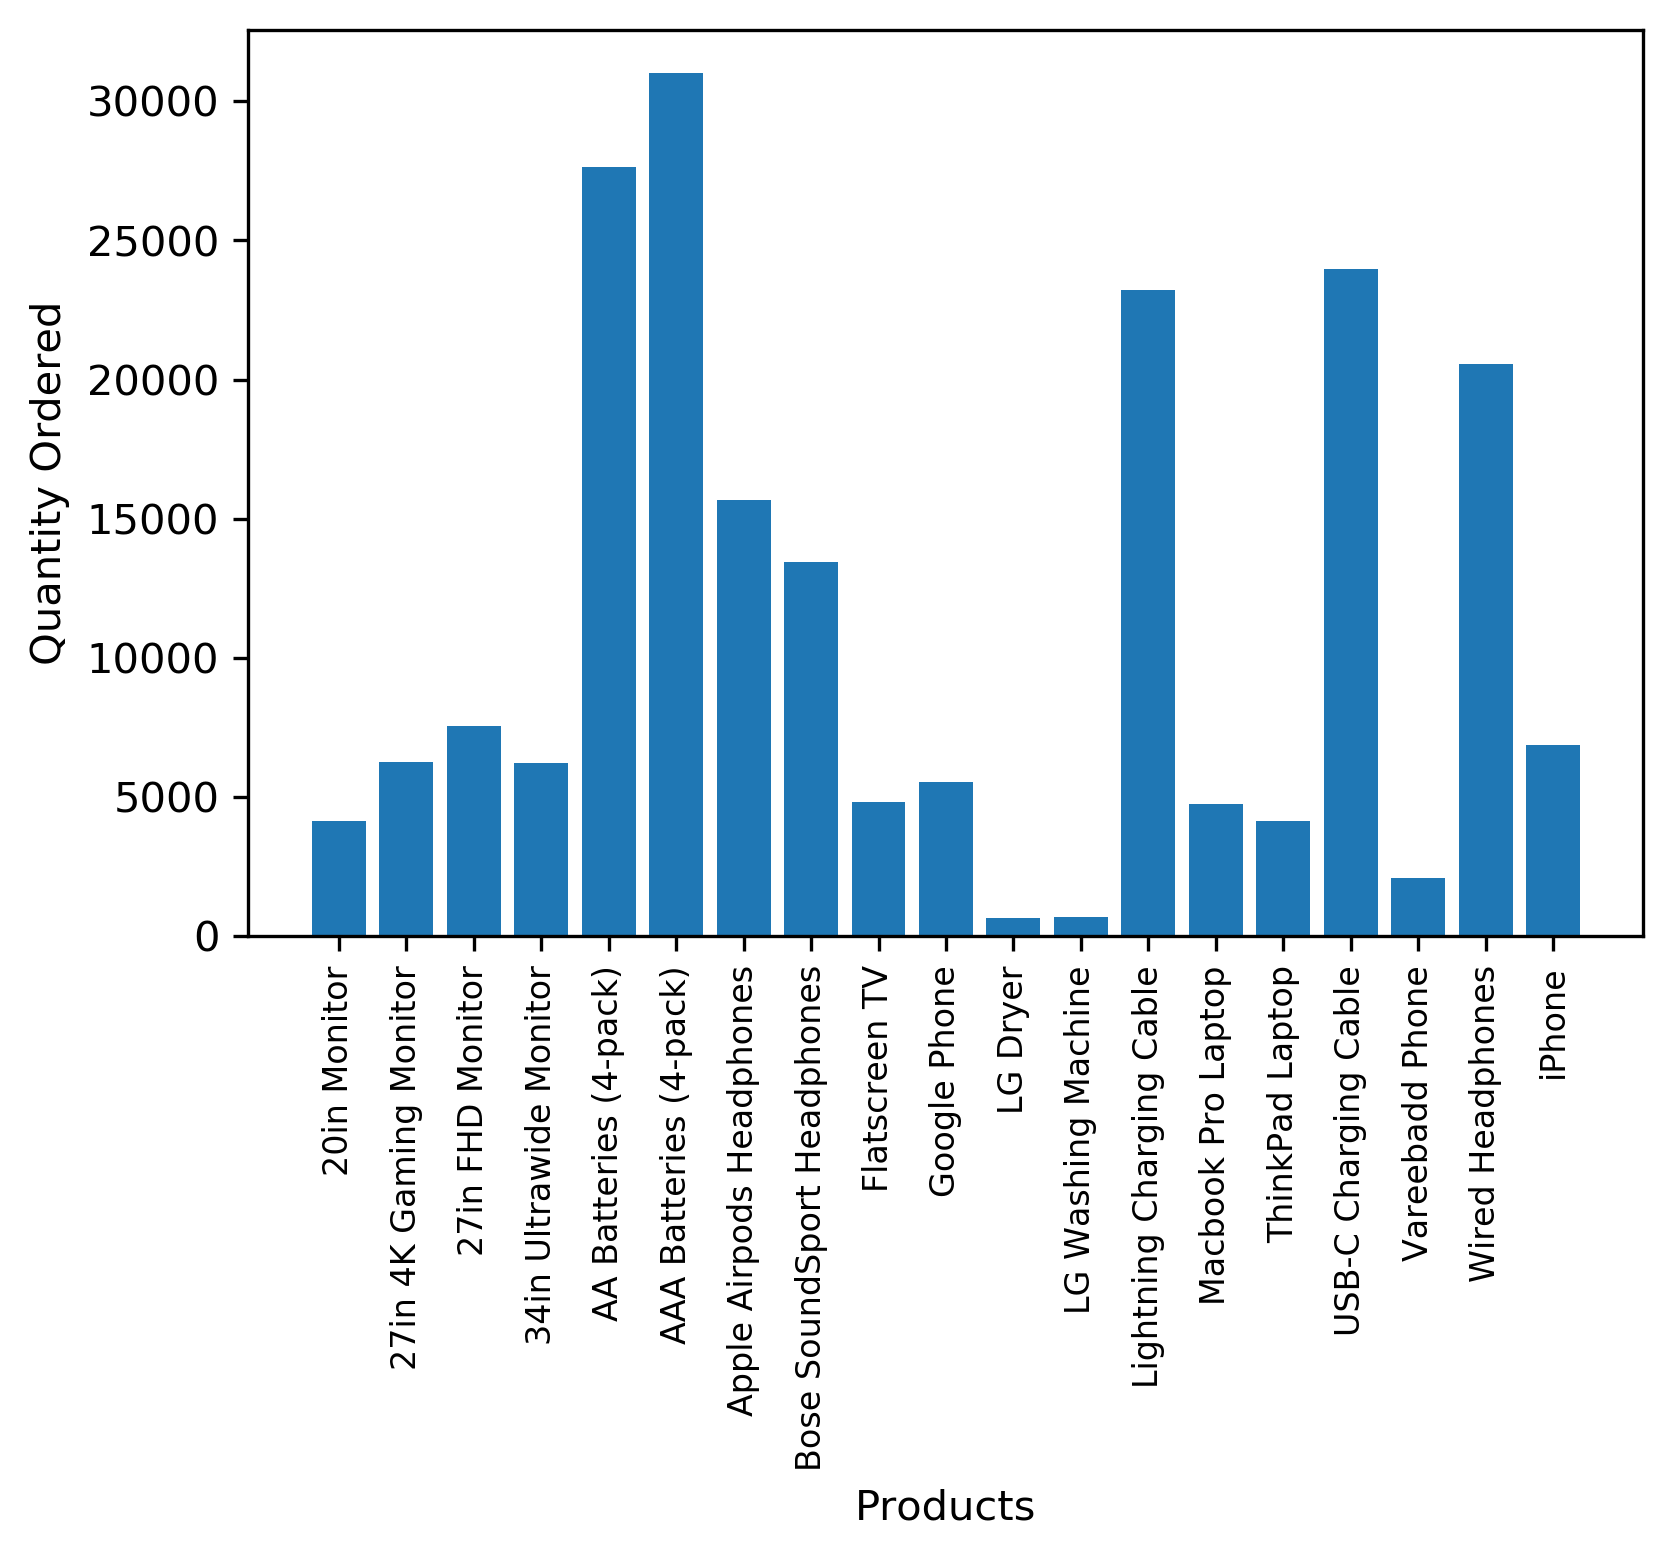

In [59]:
prd=all_data[['Product','Quantity Ordered']]
prd2=prd.groupby('Product')
#prd2.sort_values(by=['Quantity Ordered'])
q_ord=prd2.sum()['Quantity Ordered']
q_ord

# Visualize
prods=[ prods for prods, df in prd2]

plt.figure(figsize=(6,4),dpi=300)
plt.bar(prods,q_ord)
plt.xticks(prods,rotation='vertical',size=8)
plt.ylabel('Quantity Ordered')
plt.xlabel('Products')

plt.show()

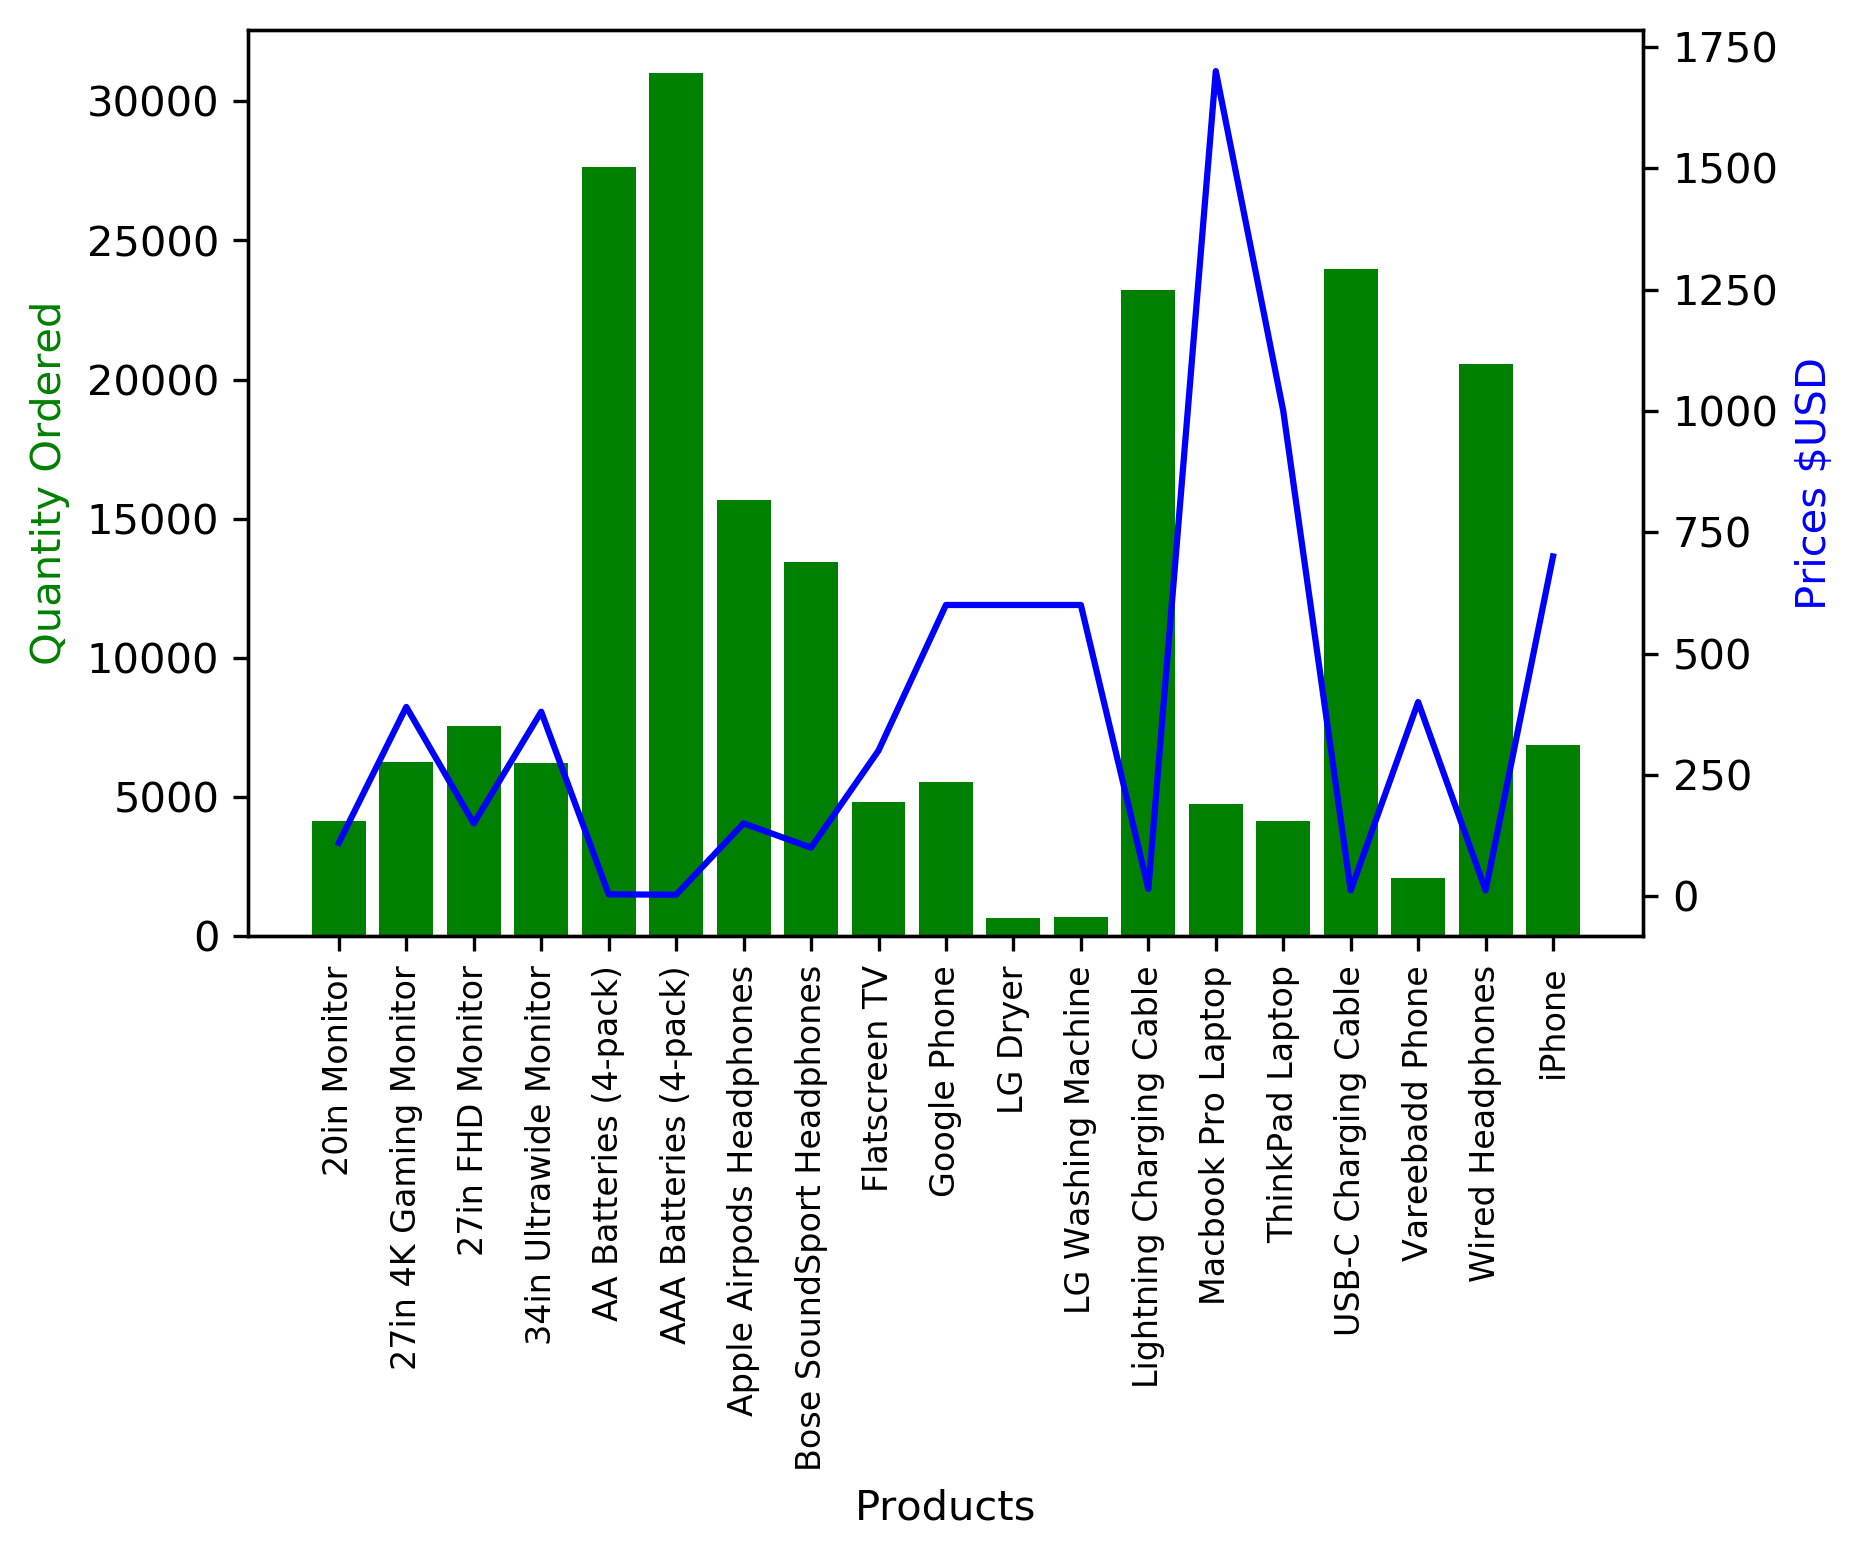

In [71]:
prices=all_data.groupby('Product').mean()['Price Each']
# Visualize (as previous)
prods=[ prods for prods, df in prd2]

# Second y axis

fig, ax1 = plt.subplots(figsize=(6,4),dpi=300)


ax2 = ax1.twinx()
ax1.bar(prods,q_ord,color='green')
ax2.plot(prods,prices,'b-')

ax1.set_xlabel('Products')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Prices $USD', color='b')
ax1.set_xticklabels(prods,rotation='vertical',size=8)

plt.show()